<a href="https://colab.research.google.com/github/rsanchezgarc/AI-ML-analytics-IE/blob/main/notebooks/lecture_3/house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

house_prices_advanced_regression_techniques_path = kagglehub.competition_download('house-prices-advanced-regression-techniques')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
test_path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
data_description_path = '/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt'
sample_submission_path = '/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv'

# Load the train dataset
data = pd.read_csv(train_path)

# Display the first few rows
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Missing values per column:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


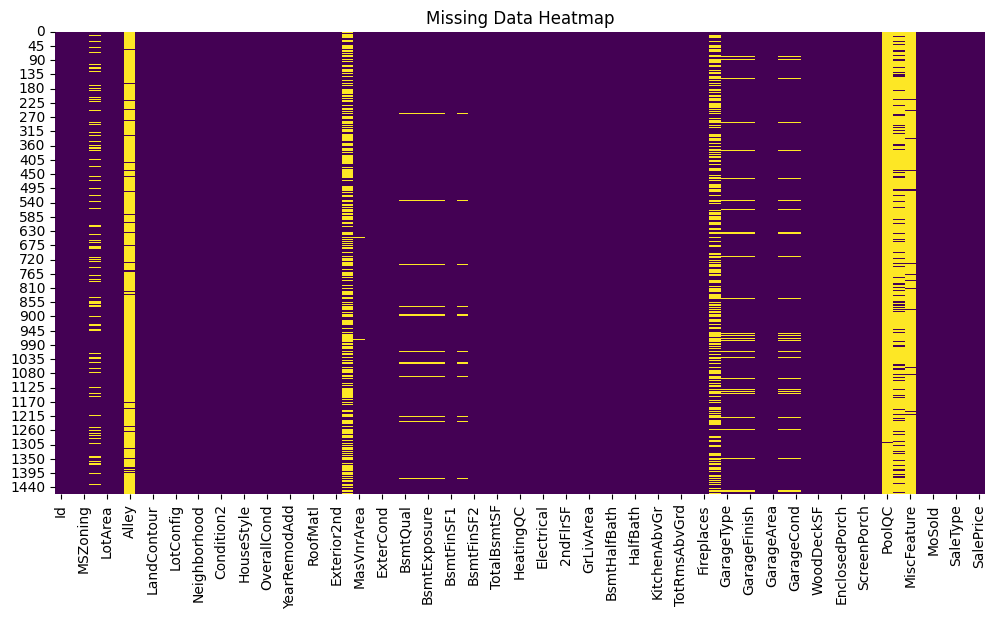

N elements  1460
                count unique     top  freq          mean           std  \
Id             1460.0    NaN     NaN   NaN         730.5    421.610009   
MSSubClass     1460.0    NaN     NaN   NaN      56.89726     42.300571   
MSZoning         1460      5      RL  1151           NaN           NaN   
LotFrontage    1201.0    NaN     NaN   NaN     70.049958     24.284752   
LotArea        1460.0    NaN     NaN   NaN  10516.828082   9981.264932   
...               ...    ...     ...   ...           ...           ...   
MoSold         1460.0    NaN     NaN   NaN      6.321918      2.703626   
YrSold         1460.0    NaN     NaN   NaN   2007.815753      1.328095   
SaleType         1460      9      WD  1267           NaN           NaN   
SaleCondition    1460      6  Normal  1198           NaN           NaN   
SalePrice      1460.0    NaN     NaN   NaN  180921.19589  79442.502883   

                   min       25%       50%       75%       max  
Id                 1.0    365

In [ ]:
missing_values = data.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

print("N elements ", len(data))
# Display summary statistics
print(data.describe(include='all').T)
#Remove columns with more than 400 missing NaNs
good_colum_names = [data.columns[i] for i,count in enumerate(missing_values) if count<400]
data = data[good_colum_names]

In [ ]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Separate numerical and categorical columns
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

# Impute missing values
data[num_cols] = num_imputer.fit_transform(data[num_cols])
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Verify no missing values remain
print("Remaining missing values per column:")
print(data.isnull().sum().sum())


Remaining missing values per column:
0


In [ ]:
# Apply label encoding to categorical columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Display encoded data sample
data.head()

,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,3,3,0,4,0,5,2,2,0,...,0.0,2,2,2,0.0,2.0,2008.0,8,4,208500.0
1,0,3,3,0,2,0,24,1,2,0,...,0.0,2,2,2,0.0,5.0,2007.0,8,4,181500.0
2,0,0,3,0,4,0,5,2,2,0,...,0.0,2,2,2,0.0,9.0,2008.0,8,4,223500.0
3,0,0,3,0,0,0,6,2,2,0,...,0.0,2,2,2,0.0,2.0,2006.0,8,0,140000.0
4,0,0,3,0,2,0,15,2,2,0,...,0.0,2,2,2,0.0,12.0,2008.0,8,4,250000.0


In [ ]:
target = 'SalePrice'
X = data.drop(columns=[target])
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the split
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (1168, 74)
Testing data shape: (292, 74)


There is something important that I am not doing here. Feature scaling. I am not doing it because random forests can handle different scales for different features, but in things like a linear model or a deep learning model, feature scaling (aka, input normalization), is critical

Mean Squared Error: 832255256.8570155
R^2 Score: 0.891496758498069


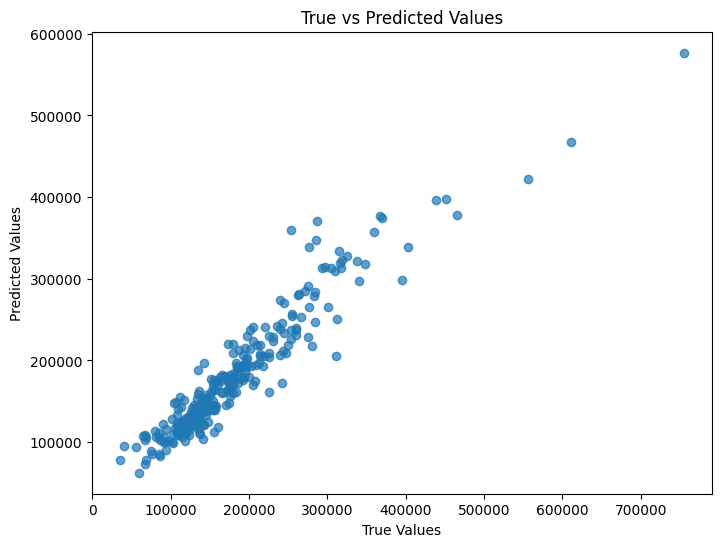

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_estimators=100)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()


Feature Importances:
        Feature    Importance
11  OverallQual  5.565810e-01
40    GrLivArea  1.270769e-01
32  TotalBsmtSF  3.668365e-02
38     2ndFlrSF  3.542878e-02
28   BsmtFinSF1  3.120254e-02
..          ...           ...
69      MiscVal  7.560827e-05
58   GarageCond  7.278679e-05
0         Alley  3.329112e-05
68  MiscFeature  1.016531e-05
3     Utilities  1.043304e-07

[74 rows x 2 columns]


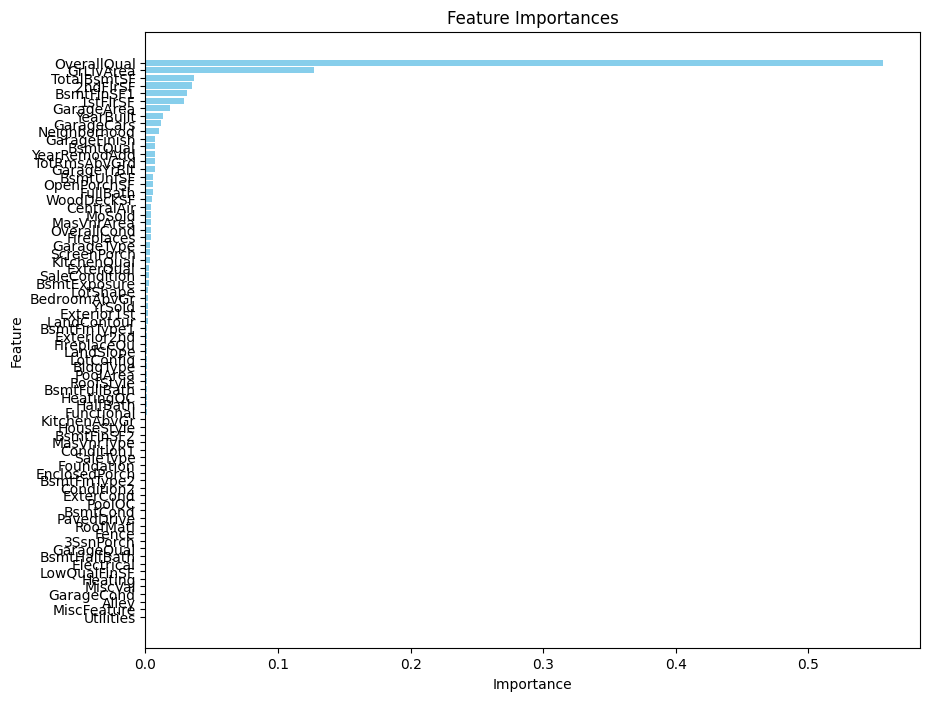

In [ ]:
# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print("Feature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
"""Id,SalePrice
1461,169000.1
1462,187724.1233
1463,175221
etc.
"""

def predict_test_set(model):
    test_data = pd.read_csv(test_path)
    ids = test_data["Id"]
    test_data[target] = 0 #Adding the target colum because the inputers where fitted with it
    test_data = test_data[good_colum_names] #good_colum_names used in the training process

    print(num_imputer.feature_names_in_)
    test_data[num_cols] = num_imputer.transform(test_data[num_cols])
    test_data[cat_cols] = cat_imputer.transform(test_data[cat_cols])
    for col in cat_cols:
        le = label_encoders[col]
        test_data[col] = le.transform(test_data[col])
    del test_data[target]

    # Make predictions on the test data
    test_predictions = model.predict(test_data)
    # Create a submission DataFrame
    submission_df = pd.DataFrame({'Id': ids.astype(np.int64), 'SalePrice': test_predictions})

    # Save the submission DataFrame to a csv file
    submission_df.to_csv('submission.csv', index=False)

    # Display the first few rows of the submission file
    print(submission_df.head().to_markdown(index=False, numalign="left", stralign="left"))

predict_test_set(rf)

['OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'MasVnrArea'
 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF'
 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces'
 'GarageYrBlt' 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF'
 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold'
 'YrSold' 'SalePrice']
| Id   | SalePrice   |
|:-----|:------------|
| 1461 | 127183      |
| 1462 | 153280      |
| 1463 | 175948      |
| 1464 | 186676      |
| 1465 | 206818      |


Since there is people that asked, I also added an example of anomaly/outliers detection using a non supervised method, the isolation forest. In many cases,it makes sense to remove outliers before training a supervised model. It is much better if the outlier removal method and the supervised method are based on different principles.

In [ ]:
#Outlier detection with isolation forest

from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

# Assuming X_train and y_train are your feature and target sets

# Combine X_train and y_train into a single DataFrame for easier processing
data = pd.concat([X_train, y_train], axis=1)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Set contamination to 5% for example

# Fit the model to the data (X_train + y_train)
iso_forest.fit(data)

# Get the predictions (-1 indicates outliers, 1 indicates inliers)
predictions = iso_forest.predict(data)

# Keep only the inliers (where prediction is 1)
inliers = predictions == 1

# Filter out the outliers from both X_train and y_train
X_train_filtered = X_train[inliers]
y_train_filtered = y_train[inliers]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
#Outlier detection with kNN

from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Combine X_train and y_train into a single DataFrame for easier processing
data = pd.concat([X_train, y_train], axis=1)

# Initialize the kNN model (you can adjust the number of neighbors)
knn = NearestNeighbors(n_neighbors=5)  # Using 5 nearest neighbors, for example

# Fit the model to the data
knn.fit(data)

# Get the distances and indices of the nearest neighbors
distances, indices = knn.kneighbors(data)

# Calculate the mean distance to the nearest neighbors for each data point
mean_distances = np.mean(distances, axis=1)

# Set a threshold for the maximum acceptable distance to consider a point as an outlier
threshold = np.percentile(mean_distances, 95)  # For example, consider points in the top 5% of distances as outliers

# Identify outliers: if mean distance is greater than threshold, it's an outlier
outliers = mean_distances > threshold

# Filter out the outliers from both X_train and y_train
X_train_filtered = X_train[~outliers]
y_train_filtered = y_train[~outliers]
print(len(y_train_filtered), len(y_train))

1109 1168


You can now try if using X_train_filtered is a good idea or not

Mean Squared Error: 1740796443.760514
R^2 Score: 0.7730479256371938


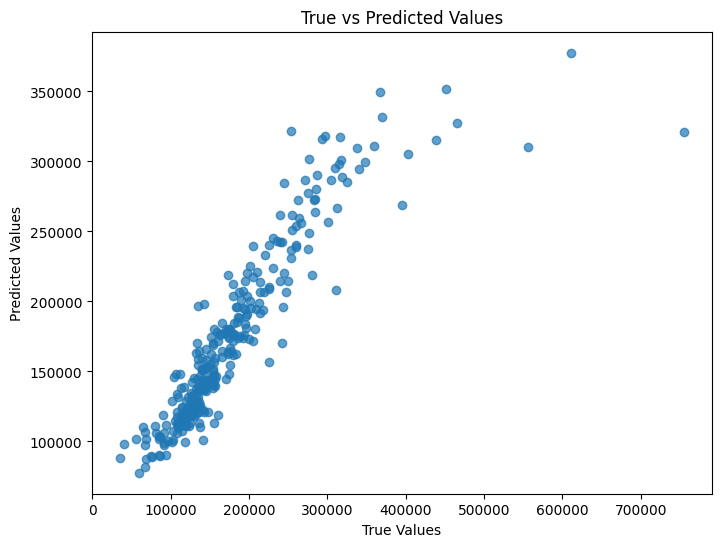

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_estimators=100)

# Train the model
rf.fit(X_train_filtered, y_train_filtered)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()


This is an example of how to do automatic hyperparameter tuning

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor  # Use RandomForestClassifier if it's a classification problem
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression  # Use your own X_train and y_train here
from sklearn.metrics import mean_squared_error
import numpy as np


# Define the objective function for Optuna. This will contain the full training
# and scoring of the validation set process.
def objective(trial):
    # Hyperparameter search space
    param_grid = {
        'n_estimators': 200,  # Number of trees in the forest
        'max_depth': trial.suggest_int('max_depth', 2, 50),  # Maximum depth of trees
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),  # Minimum samples at a leaf node
        'max_features': trial.suggest_categorical('max_features', [1.0, 'sqrt', 'log2']),  # Maximum number of features to consider,
    }

    # Initialize the RandomForestRegressor with the suggested hyperparameters
    model = RandomForestRegressor(**param_grid, random_state=42)

    # Cross-validation score (using negative mean squared error as an example)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(score)
    # We return the negative mean of the cross-validation score as the objective to minimize
    return -score.mean()

# Create a study object to optimize the objective function
study = optuna.create_study(direction='minimize')  # Minimize negative mean squared error
study.optimize(objective, n_trials=100)  # You can adjust n_trials based on your computational budget

# Output the best hyperparameters found
print(f"Best hyperparameters: {study.best_params}")

# You can now use the best parameters to train your final model:
best_params = study.best_params
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")



[I 2025-01-15 11:33:38,592] A new study created in memory with name: no-name-9fb2a240-2340-4515-9240-ca2dc3e280be
[I 2025-01-15 11:33:50,403] Trial 0 finished with value: 947256437.4672115 and parameters: {'max_depth': 37, 'min_samples_leaf': 2, 'max_features': 1.0}. Best is trial 0 with value: 947256437.4672115.


[-8.50955424e+08 -1.26630709e+09 -1.36898491e+09 -6.08868514e+08
 -6.41166247e+08]


[I 2025-01-15 11:33:53,049] Trial 1 finished with value: 980728651.1785858 and parameters: {'max_depth': 22, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 947256437.4672115.


[-1.01996242e+09 -1.06172978e+09 -1.52104424e+09 -7.25964470e+08
 -5.74942349e+08]


[I 2025-01-15 11:33:55,451] Trial 2 finished with value: 1047864544.4433447 and parameters: {'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 947256437.4672115.


[-1.18824964e+09 -9.98150608e+08 -1.63853702e+09 -7.93002261e+08
 -6.21383188e+08]


[I 2025-01-15 11:33:57,566] Trial 3 finished with value: 1184688673.175988 and parameters: {'max_depth': 23, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 947256437.4672115.


[-1.35745256e+09 -1.01458500e+09 -1.82738385e+09 -9.61714123e+08
 -7.62307838e+08]


[I 2025-01-15 11:34:00,242] Trial 4 finished with value: 980728651.1785858 and parameters: {'max_depth': 46, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 947256437.4672115.


[-1.01996242e+09 -1.06172978e+09 -1.52104424e+09 -7.25964470e+08
 -5.74942349e+08]


[I 2025-01-15 11:34:02,573] Trial 5 finished with value: 1091366048.3556838 and parameters: {'max_depth': 23, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 947256437.4672115.


[-1.24244982e+09 -1.01026996e+09 -1.68745444e+09 -8.52059354e+08
 -6.64596668e+08]


[I 2025-01-15 11:34:10,268] Trial 6 finished with value: 1046326229.428935 and parameters: {'max_depth': 32, 'min_samples_leaf': 9, 'max_features': 1.0}. Best is trial 0 with value: 947256437.4672115.


[-1.05828631e+09 -1.08978506e+09 -1.67343737e+09 -6.83623855e+08
 -7.26498546e+08]


[I 2025-01-15 11:34:13,151] Trial 7 finished with value: 944768460.6144571 and parameters: {'max_depth': 48, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 944768460.6144571.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:34:20,875] Trial 8 finished with value: 1046327741.6341482 and parameters: {'max_depth': 11, 'min_samples_leaf': 9, 'max_features': 1.0}. Best is trial 7 with value: 944768460.6144571.


[-1.05820295e+09 -1.08978052e+09 -1.67348478e+09 -6.83645530e+08
 -7.26524926e+08]


[I 2025-01-15 11:34:22,955] Trial 9 finished with value: 1170000636.64679 and parameters: {'max_depth': 16, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 7 with value: 944768460.6144571.


[-1.34145552e+09 -1.01323054e+09 -1.80080613e+09 -9.47504149e+08
 -7.47006853e+08]


[I 2025-01-15 11:34:26,380] Trial 10 finished with value: 920960687.1385458 and parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:34:29,860] Trial 11 finished with value: 920960687.1385458 and parameters: {'max_depth': 49, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:34:33,286] Trial 12 finished with value: 920960687.1385458 and parameters: {'max_depth': 42, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:34:35,711] Trial 13 finished with value: 1037070459.8917602 and parameters: {'max_depth': 49, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.15647894e+09 -9.84904856e+08 -1.63113880e+09 -8.03120218e+08
 -6.09709485e+08]


[I 2025-01-15 11:34:38,766] Trial 14 finished with value: 938308591.8552363 and parameters: {'max_depth': 39, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 10 with value: 920960687.1385458.


[-9.35382708e+08 -1.02862808e+09 -1.41792612e+09 -7.35385444e+08
 -5.74220607e+08]


[I 2025-01-15 11:34:41,311] Trial 15 finished with value: 1010118206.0024853 and parameters: {'max_depth': 32, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.10927415e+09 -1.04115747e+09 -1.54735767e+09 -7.66982413e+08
 -5.85819323e+08]


[I 2025-01-15 11:34:44,742] Trial 16 finished with value: 920960687.1385458 and parameters: {'max_depth': 43, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:34:47,116] Trial 17 finished with value: 1064455954.7236016 and parameters: {'max_depth': 49, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.16879891e+09 -9.94519289e+08 -1.66137266e+09 -8.32683528e+08
 -6.64905378e+08]


[I 2025-01-15 11:34:57,436] Trial 18 finished with value: 963244876.1055235 and parameters: {'max_depth': 36, 'min_samples_leaf': 3, 'max_features': 1.0}. Best is trial 10 with value: 920960687.1385458.


[-8.44691545e+08 -1.26094045e+09 -1.44613614e+09 -6.12057850e+08
 -6.52398397e+08]


[I 2025-01-15 11:35:00,109] Trial 19 finished with value: 972095349.9518868 and parameters: {'max_depth': 43, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 10 with value: 920960687.1385458.


[-1.02156434e+09 -1.04993571e+09 -1.48200258e+09 -7.40482819e+08
 -5.66491299e+08]


[I 2025-01-15 11:35:02,685] Trial 20 finished with value: 1010118206.0024853 and parameters: {'max_depth': 27, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.10927415e+09 -1.04115747e+09 -1.54735767e+09 -7.66982413e+08
 -5.85819323e+08]


[I 2025-01-15 11:35:06,090] Trial 21 finished with value: 920960687.1385458 and parameters: {'max_depth': 43, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:35:09,513] Trial 22 finished with value: 920960687.1385458 and parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:35:12,417] Trial 23 finished with value: 944768460.6144571 and parameters: {'max_depth': 41, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:35:14,463] Trial 24 finished with value: 1227267726.0138905 and parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.23554121e+09 -1.27209449e+09 -1.85590804e+09 -9.83130889e+08
 -7.89664007e+08]


[I 2025-01-15 11:35:16,997] Trial 25 finished with value: 1010118206.0024853 and parameters: {'max_depth': 46, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.10927415e+09 -1.04115747e+09 -1.54735767e+09 -7.66982413e+08
 -5.85819323e+08]


[I 2025-01-15 11:35:19,637] Trial 26 finished with value: 980728651.1785858 and parameters: {'max_depth': 46, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.01996242e+09 -1.06172978e+09 -1.52104424e+09 -7.25964470e+08
 -5.74942349e+08]


[I 2025-01-15 11:35:22,540] Trial 27 finished with value: 944768460.6144571 and parameters: {'max_depth': 35, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:35:25,608] Trial 28 finished with value: 938308591.8552363 and parameters: {'max_depth': 40, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 10 with value: 920960687.1385458.


[-9.35382708e+08 -1.02862808e+09 -1.41792612e+09 -7.35385444e+08
 -5.74220607e+08]


[I 2025-01-15 11:35:37,255] Trial 29 finished with value: 947256437.4672115 and parameters: {'max_depth': 33, 'min_samples_leaf': 2, 'max_features': 1.0}. Best is trial 10 with value: 920960687.1385458.


[-8.50955424e+08 -1.26630709e+09 -1.36898491e+09 -6.08868514e+08
 -6.41166247e+08]


[I 2025-01-15 11:35:45,827] Trial 30 finished with value: 996086424.2842548 and parameters: {'max_depth': 38, 'min_samples_leaf': 6, 'max_features': 1.0}. Best is trial 10 with value: 920960687.1385458.


[-9.68855293e+08 -1.11428152e+09 -1.58670941e+09 -6.30584391e+08
 -6.80001506e+08]


[I 2025-01-15 11:35:49,234] Trial 31 finished with value: 920960687.1385458 and parameters: {'max_depth': 44, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:35:52,702] Trial 32 finished with value: 920960687.1385458 and parameters: {'max_depth': 42, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:35:55,351] Trial 33 finished with value: 980728651.1785858 and parameters: {'max_depth': 46, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.01996242e+09 -1.06172978e+09 -1.52104424e+09 -7.25964470e+08
 -5.74942349e+08]


[I 2025-01-15 11:35:58,207] Trial 34 finished with value: 944768460.6144571 and parameters: {'max_depth': 45, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:36:00,453] Trial 35 finished with value: 1169004805.516457 and parameters: {'max_depth': 50, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.35759716e+09 -1.01507823e+09 -1.81456481e+09 -9.32857452e+08
 -7.24926373e+08]


[I 2025-01-15 11:36:03,356] Trial 36 finished with value: 944768460.6144571 and parameters: {'max_depth': 47, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:36:07,017] Trial 37 finished with value: 920960687.1385458 and parameters: {'max_depth': 41, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:36:09,907] Trial 38 finished with value: 944768460.6144571 and parameters: {'max_depth': 29, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:36:12,237] Trial 39 finished with value: 1036548461.4646553 and parameters: {'max_depth': 37, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 10 with value: 920960687.1385458.


[-1.13370249e+09 -9.74947316e+08 -1.61488300e+09 -8.28510546e+08
 -6.30698949e+08]


[I 2025-01-15 11:36:14,947] Trial 40 finished with value: 980728651.1785858 and parameters: {'max_depth': 48, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.01996242e+09 -1.06172978e+09 -1.52104424e+09 -7.25964470e+08
 -5.74942349e+08]


[I 2025-01-15 11:36:18,414] Trial 41 finished with value: 920960687.1385458 and parameters: {'max_depth': 43, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:36:21,959] Trial 42 finished with value: 920960687.1385458 and parameters: {'max_depth': 44, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:36:24,861] Trial 43 finished with value: 944768460.6144571 and parameters: {'max_depth': 39, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:36:28,369] Trial 44 finished with value: 920960687.1385458 and parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:36:38,811] Trial 45 finished with value: 963396714.8445383 and parameters: {'max_depth': 17, 'min_samples_leaf': 3, 'max_features': 1.0}. Best is trial 10 with value: 920960687.1385458.


[-8.44973756e+08 -1.26019666e+09 -1.44746203e+09 -6.11182414e+08
 -6.53168715e+08]


[I 2025-01-15 11:36:42,323] Trial 46 finished with value: 920960687.1385458 and parameters: {'max_depth': 48, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:36:44,573] Trial 47 finished with value: 1109562778.25393 and parameters: {'max_depth': 34, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.30630755e+09 -1.00966774e+09 -1.70112037e+09 -8.78625799e+08
 -6.52092425e+08]


[I 2025-01-15 11:36:47,709] Trial 48 finished with value: 938308591.8552363 and parameters: {'max_depth': 43, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 10 with value: 920960687.1385458.


[-9.35382708e+08 -1.02862808e+09 -1.41792612e+09 -7.35385444e+08
 -5.74220607e+08]


[I 2025-01-15 11:36:50,668] Trial 49 finished with value: 944768460.6144571 and parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:36:53,382] Trial 50 finished with value: 980728651.1785858 and parameters: {'max_depth': 25, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.01996242e+09 -1.06172978e+09 -1.52104424e+09 -7.25964470e+08
 -5.74942349e+08]


[I 2025-01-15 11:36:56,867] Trial 51 finished with value: 920960687.1385458 and parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:37:00,454] Trial 52 finished with value: 920960687.1385458 and parameters: {'max_depth': 48, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:37:03,908] Trial 53 finished with value: 920960687.1385458 and parameters: {'max_depth': 45, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-9.04950982e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24706585e+08]


[I 2025-01-15 11:37:06,769] Trial 54 finished with value: 944768460.6144571 and parameters: {'max_depth': 47, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:37:09,688] Trial 55 finished with value: 944768460.6144571 and parameters: {'max_depth': 42, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:37:23,870] Trial 56 finished with value: 925604725.4131435 and parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'max_features': 1.0}. Best is trial 10 with value: 920960687.1385458.


[-7.99983572e+08 -1.24518922e+09 -1.31444046e+09 -6.00431361e+08
 -6.67979015e+08]


[I 2025-01-15 11:37:26,730] Trial 57 finished with value: 944768460.6144571 and parameters: {'max_depth': 40, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 920960687.1385458.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:37:28,947] Trial 58 finished with value: 1086321864.2773528 and parameters: {'max_depth': 45, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 10 with value: 920960687.1385458.


[-1.22609341e+09 -1.01009488e+09 -1.68700119e+09 -8.50786327e+08
 -6.57633523e+08]


[I 2025-01-15 11:37:32,462] Trial 59 finished with value: 917358606.7737402 and parameters: {'max_depth': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 59 with value: 917358606.7737402.


[-8.91383103e+08 -1.04122597e+09 -1.43258149e+09 -6.61311280e+08
 -5.60291187e+08]


[I 2025-01-15 11:37:35,314] Trial 60 finished with value: 946015131.2790991 and parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 59 with value: 917358606.7737402.


[-1.00586853e+09 -1.02257156e+09 -1.45204086e+09 -7.10096880e+08
 -5.39497826e+08]


[I 2025-01-15 11:37:38,252] Trial 61 finished with value: 933335948.8670574 and parameters: {'max_depth': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 59 with value: 917358606.7737402.


[-9.07788186e+08 -1.07341674e+09 -1.42776582e+09 -6.96001817e+08
 -5.61707177e+08]


[I 2025-01-15 11:37:41,802] Trial 62 finished with value: 898476763.1478407 and parameters: {'max_depth': 21, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 62 with value: 898476763.1478407.


[-8.83117494e+08 -1.03610237e+09 -1.36422875e+09 -6.79578456e+08
 -5.29356753e+08]


[I 2025-01-15 11:37:45,235] Trial 63 finished with value: 898476763.1478407 and parameters: {'max_depth': 21, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 62 with value: 898476763.1478407.


[-8.83117494e+08 -1.03610237e+09 -1.36422875e+09 -6.79578456e+08
 -5.29356753e+08]


[I 2025-01-15 11:37:47,560] Trial 64 finished with value: 1091366048.3556838 and parameters: {'max_depth': 21, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 62 with value: 898476763.1478407.


[-1.24244982e+09 -1.01026996e+09 -1.68745444e+09 -8.52059354e+08
 -6.64596668e+08]


[I 2025-01-15 11:37:50,989] Trial 65 finished with value: 915017209.4118131 and parameters: {'max_depth': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 62 with value: 898476763.1478407.


[-8.71798969e+08 -1.05409041e+09 -1.42771668e+09 -6.90336071e+08
 -5.31143915e+08]


[I 2025-01-15 11:37:54,412] Trial 66 finished with value: 918223672.8928139 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 62 with value: 898476763.1478407.


[-9.30159219e+08 -9.88666226e+08 -1.45765214e+09 -7.05678832e+08
 -5.08961947e+08]


[I 2025-01-15 11:37:57,831] Trial 67 finished with value: 918223672.8928139 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 62 with value: 898476763.1478407.


[-9.30159219e+08 -9.88666226e+08 -1.45765214e+09 -7.05678832e+08
 -5.08961947e+08]


[I 2025-01-15 11:38:00,778] Trial 68 finished with value: 944549350.0073378 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 62 with value: 898476763.1478407.


[-9.93785937e+08 -1.02319228e+09 -1.44568340e+09 -7.15392787e+08
 -5.44692343e+08]


[I 2025-01-15 11:38:14,515] Trial 69 finished with value: 939163031.148493 and parameters: {'max_depth': 14, 'min_samples_leaf': 1, 'max_features': 1.0}. Best is trial 62 with value: 898476763.1478407.


[-8.05939176e+08 -1.28229220e+09 -1.34893058e+09 -5.98531144e+08
 -6.60122060e+08]


[I 2025-01-15 11:38:17,398] Trial 70 finished with value: 944703566.0966431 and parameters: {'max_depth': 23, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 62 with value: 898476763.1478407.


[-1.00337740e+09 -1.02026886e+09 -1.45414332e+09 -7.08771406e+08
 -5.36956841e+08]


[I 2025-01-15 11:38:20,649] Trial 71 finished with value: 933214315.5214357 and parameters: {'max_depth': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 62 with value: 898476763.1478407.


[-8.58008033e+08 -1.08829083e+09 -1.47647900e+09 -6.95248660e+08
 -5.48045052e+08]


[I 2025-01-15 11:38:24,105] Trial 72 finished with value: 917358606.7737402 and parameters: {'max_depth': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 62 with value: 898476763.1478407.


[-8.91383103e+08 -1.04122597e+09 -1.43258149e+09 -6.61311280e+08
 -5.60291187e+08]


[I 2025-01-15 11:38:27,528] Trial 73 finished with value: 891932444.0771828 and parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-8.49116366e+08 -1.02065292e+09 -1.37268166e+09 -6.74342702e+08
 -5.42868573e+08]


[I 2025-01-15 11:38:30,954] Trial 74 finished with value: 917358606.7737402 and parameters: {'max_depth': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-8.91383103e+08 -1.04122597e+09 -1.43258149e+09 -6.61311280e+08
 -5.60291187e+08]


[I 2025-01-15 11:38:34,368] Trial 75 finished with value: 917367358.1153002 and parameters: {'max_depth': 25, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.05527853e+08 -1.06305857e+09 -1.41931605e+09 -6.78915082e+08
 -5.20019228e+08]


[I 2025-01-15 11:38:37,245] Trial 76 finished with value: 944768460.6144571 and parameters: {'max_depth': 25, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-1.00337740e+09 -1.02018038e+09 -1.45462978e+09 -7.08697903e+08
 -5.36956841e+08]


[I 2025-01-15 11:38:40,686] Trial 77 finished with value: 917367358.1153002 and parameters: {'max_depth': 25, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.05527853e+08 -1.06305857e+09 -1.41931605e+09 -6.78915082e+08
 -5.20019228e+08]


[I 2025-01-15 11:38:43,566] Trial 78 finished with value: 946015131.2790991 and parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-1.00586853e+09 -1.02257156e+09 -1.45204086e+09 -7.10096880e+08
 -5.39497826e+08]


[I 2025-01-15 11:38:46,713] Trial 79 finished with value: 945636712.1714061 and parameters: {'max_depth': 23, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 73 with value: 891932444.0771828.


[-9.50047326e+08 -1.03135863e+09 -1.44224127e+09 -7.23628637e+08
 -5.80907700e+08]


[I 2025-01-15 11:38:49,331] Trial 80 finished with value: 980728651.1785858 and parameters: {'max_depth': 21, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-1.01996242e+09 -1.06172978e+09 -1.52104424e+09 -7.25964470e+08
 -5.74942349e+08]


[I 2025-01-15 11:38:52,810] Trial 81 finished with value: 920078725.3820002 and parameters: {'max_depth': 26, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.05765764e+08 -1.05931187e+09 -1.43072369e+09 -6.80612128e+08
 -5.23980179e+08]


[I 2025-01-15 11:38:56,174] Trial 82 finished with value: 925699236.4363775 and parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.37886187e+08 -1.04060619e+09 -1.41457837e+09 -6.95535958e+08
 -5.39889474e+08]


[I 2025-01-15 11:38:59,582] Trial 83 finished with value: 921235358.1460882 and parameters: {'max_depth': 24, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.03072453e+08 -1.07183355e+09 -1.42613445e+09 -6.82910924e+08
 -5.22225415e+08]


[I 2025-01-15 11:39:03,070] Trial 84 finished with value: 891932444.0771828 and parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-8.49116366e+08 -1.02065292e+09 -1.37268166e+09 -6.74342702e+08
 -5.42868573e+08]


[I 2025-01-15 11:39:05,917] Trial 85 finished with value: 946015131.2790991 and parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-1.00586853e+09 -1.02257156e+09 -1.45204086e+09 -7.10096880e+08
 -5.39497826e+08]


[I 2025-01-15 11:39:09,244] Trial 86 finished with value: 925511054.7916685 and parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.11875304e+08 -1.04007639e+09 -1.43793591e+09 -6.94160245e+08
 -5.43507424e+08]


[I 2025-01-15 11:39:12,179] Trial 87 finished with value: 943333863.5942125 and parameters: {'max_depth': 22, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-1.00337740e+09 -1.02122832e+09 -1.44747202e+09 -7.08966204e+08
 -5.35625374e+08]


[I 2025-01-15 11:39:26,269] Trial 88 finished with value: 925887805.6219107 and parameters: {'max_depth': 19, 'min_samples_leaf': 1, 'max_features': 1.0}. Best is trial 73 with value: 891932444.0771828.


[-8.07967119e+08 -1.24698810e+09 -1.31075797e+09 -6.00391817e+08
 -6.63334014e+08]


[I 2025-01-15 11:39:29,702] Trial 89 finished with value: 921007068.850778 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.05498186e+08 -1.06477608e+09 -1.43177988e+09 -6.78589903e+08
 -5.24391290e+08]


[I 2025-01-15 11:39:33,204] Trial 90 finished with value: 919566471.0435927 and parameters: {'max_depth': 22, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.06418831e+08 -1.06432850e+09 -1.39323392e+09 -6.94047210e+08
 -5.39803894e+08]


[I 2025-01-15 11:39:36,574] Trial 91 finished with value: 915017209.4118131 and parameters: {'max_depth': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-8.71798969e+08 -1.05409041e+09 -1.42771668e+09 -6.90336071e+08
 -5.31143915e+08]


[I 2025-01-15 11:39:39,683] Trial 92 finished with value: 915528776.8640391 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-8.98777453e+08 -1.01020899e+09 -1.42530330e+09 -7.03476065e+08
 -5.39878077e+08]


[I 2025-01-15 11:39:42,436] Trial 93 finished with value: 953480791.7372183 and parameters: {'max_depth': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.02724698e+08 -1.09994102e+09 -1.46669162e+09 -7.23887690e+08
 -5.74158934e+08]


[I 2025-01-15 11:39:45,281] Trial 94 finished with value: 958374719.7269844 and parameters: {'max_depth': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-1.00851665e+09 -1.09827906e+09 -1.42453514e+09 -7.17424667e+08
 -5.43118081e+08]


[I 2025-01-15 11:39:48,737] Trial 95 finished with value: 925699236.4363775 and parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.37886187e+08 -1.04060619e+09 -1.41457837e+09 -6.95535958e+08
 -5.39889474e+08]


[I 2025-01-15 11:39:51,007] Trial 96 finished with value: 1169004805.516457 and parameters: {'max_depth': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-1.35759716e+09 -1.01507823e+09 -1.81456481e+09 -9.32857452e+08
 -7.24926373e+08]


[I 2025-01-15 11:39:53,928] Trial 97 finished with value: 945087655.0798168 and parameters: {'max_depth': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.96857133e+08 -1.02097341e+09 -1.45216679e+09 -7.10957666e+08
 -5.44483279e+08]


[I 2025-01-15 11:39:56,124] Trial 98 finished with value: 1105137328.622741 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 73 with value: 891932444.0771828.


[-1.25300876e+09 -1.01022009e+09 -1.68293901e+09 -8.85467639e+08
 -6.94051145e+08]


[I 2025-01-15 11:39:58,839] Trial 99 finished with value: 953480791.7372183 and parameters: {'max_depth': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 73 with value: 891932444.0771828.


[-9.02724698e+08 -1.09994102e+09 -1.46669162e+09 -7.23887690e+08
 -5.74158934e+08]
Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Mean Squared Error: 998548332.8962172
R^2 Score: 0.8698167058448474
